In [2]:
!pip install pmdarima
import pmdarima as pm
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit
import pandas as pd
import numpy as np
import datetime
import requests
import warnings

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates

from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import OrdinalEncoder

from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
from sklearn.preprocessing import StandardScaler

#!pip install fbprophet
#from fbprophet import Prophet
#from fbprophet.plot import plot_plotly, add_changepoints_to_plot
#from keras.models import Sequential
#from keras.layers import Dense

#from keras.optimizers import Adam

warnings.filterwarnings('ignore')

In [3]:
covid_df  = pd.read_csv('california_uni.csv')
covid_df = covid_df.drop('PROVINCE_STATE_NAME', axis=1)
covid_df  = covid_df.set_index('Date')
covid_df.index = pd.to_datetime(covid_df.index)

In [4]:
covid_df=covid_df.sort_index()

In [5]:
train_size = int(len(covid_df) * 0.8)
cali_train, cali_test = covid_df[0:train_size], covid_df[train_size:]

In [6]:
cali_test

,PEOPLE_POSITIVE_NEW_CASES_COUNT
Date,
2021-11-23,4541
2021-11-24,4168
2021-11-25,2
2021-11-26,1990
2021-11-27,618
...,...
2022-04-25,4531
2022-04-26,16180
2022-04-27,1852


## ARIMA

In [20]:
from statsmodels.tsa.arima.model import ARIMA
base_cali_arima = ARIMA(cali_train, order=(2, 0, 1))
base_cali_arima_fit = base_cali_arima.fit()

In [21]:
base_cali_arima_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:     PEOPLE_POSITIVE_NEW_CASES_COUNT   No. Observations:                  632
Model:                              ARIMA(2, 0, 1)   Log Likelihood               -6201.017
Date:                             Thu, 22 Feb 2024   AIC                          12412.034
Time:                                     16:15:03   BIC                          12434.278
Sample:                                 03-01-2020   HQIC                         12420.673
                                      - 11-22-2021                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       7992.7056   5936.418      1.346      0.178   -3642.460    1.96e+04
ar.L1          0.8817      0.029     30.284      0.000       0.825       0.939
ar.L2          0.1081      0.028      3.890      0.000       0.054       0.163
ma.L1         -0.6885      0.023    -30.454      0.000      -0.733      -0.644
sigma2      2.094e+07     96.995   2.16e+05      0.000    2.09e+07    2.09e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):             81257.44
Prob(Q):                              0.81   Prob(JB):                         0.00
Heteroskedasticity (H):              32.69   Skew:                             4.76
Prob(H) (two-sided):                  0.00   Kurtosis:                        57.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.53e+19. Standard errors may be unstable.
"""

<AxesSubplot:xlabel='Date'>

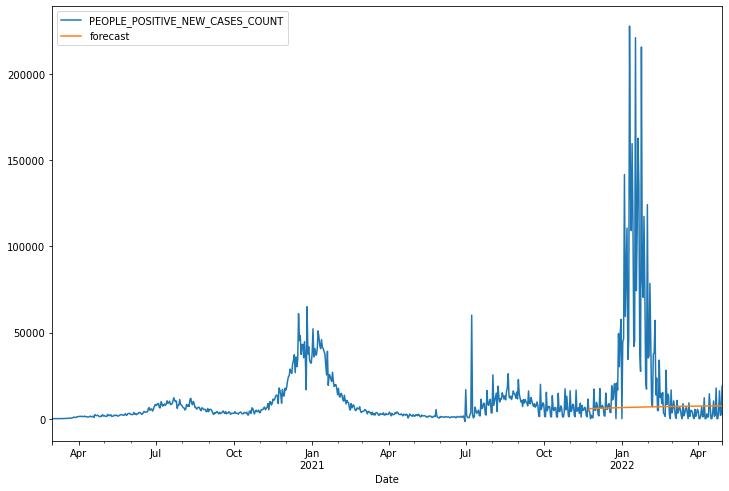

In [29]:
#covid_df['forecast']= base_cali_arima_fit.predict(start=90,end=103,dynamic=True)
covid_df['forecast']= base_cali_arima_fit.forecast(steps = len(cali_test))
covid_df[['PEOPLE_POSITIVE_NEW_CASES_COUNT','forecast']].plot(figsize=(12,8))

In [42]:
results=[]
for p in range(1,5):
    for q in range(1,5):
 #       cali_arima_gmodel=ARIMA(cali_train['PEOPLE_POSITIVE_NEW_CASES_COUNT'],order=(p,1,q)).fit()
        cali_arima_gmodel=ARIMA(cali_train,order=(p,1,q)).fit()
        results.append([p,q,cali_arima_gmodel.aic])
pd.DataFrame(results, columns=['p','q','aic']).sort_values('aic')

,p,q,aic
7,2,4,12356.459536
11,3,4,12358.861759
15,4,4,12360.410548
1,1,2,12367.302104
6,2,3,12368.199288
5,2,2,12368.483423
10,3,3,12369.689054
9,3,2,12370.674818
14,4,3,12371.559881
2,1,3,12371.577505


In [32]:
# For non-seasonal data
#p=1, d=1, q=0 or 1
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima.model import ARIMA

In [43]:
#cali_after_gmodel=ARIMA(cali_train['PEOPLE_POSITIVE_NEW_CASES_COUNT'],order=(2,1,4))
cali_after_gmodel=ARIMA(cali_train,order=(2,1,4))
cali_after_gmodel_fit =cali_after_gmodel.fit()

<AxesSubplot:xlabel='Date'>

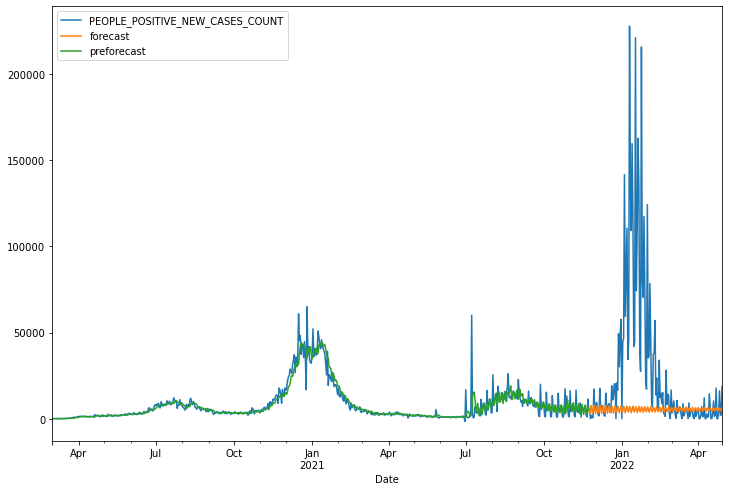

In [47]:
covid_df['forecast']= cali_after_gmodel_fit.forecast(steps = len(cali_test))
covid_df['preforecast']= cali_after_gmodel_fit.predict(start = 0, end = 632)
covid_df[['PEOPLE_POSITIVE_NEW_CASES_COUNT','forecast', 'preforecast']].plot(figsize=(12,8))

In [39]:
cali_train

,PEOPLE_POSITIVE_NEW_CASES_COUNT
Date,
2020-03-01,5
2020-03-02,5
2020-03-03,7
2020-03-04,10
2020-03-05,12
...,...
2021-11-18,6627
2021-11-19,6090
2021-11-20,1853


## SARIMA

In [7]:
import statsmodels.api as sm

In [8]:
cali_sarima= sm.tsa.statespace.SARIMAX(cali_train,order=(1, 1, 1),seasonal_order=(1,1,1,12))
results_sarima = cali_sarima.fit()

<AxesSubplot:xlabel='Date'>

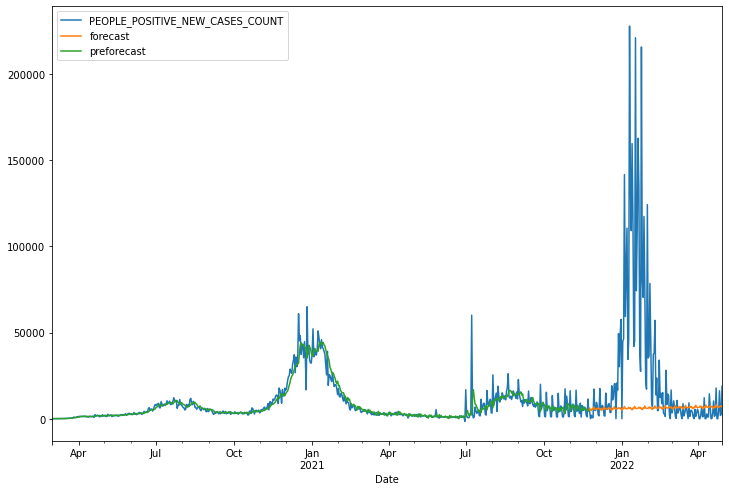

In [9]:
covid_df['forecast']= results_sarima.forecast(steps = len(cali_test))
covid_df['preforecast'] = results_sarima.predict(start = 0, end = 632)
covid_df[['PEOPLE_POSITIVE_NEW_CASES_COUNT','forecast', 'preforecast']].plot(figsize=(12,8))

In [25]:
import warnings
import statsmodels.api 
warnings.filterwarnings("ignore",category = statsmodels.tools.sm_exceptions.ConvergenceWarning)
warnings.filterwarnings("ignore",category =  UserWarning)
warnings.filterwarnings("ignore",category = statsmodels.tools.sm_exceptions.ValueWarning)

if 1:
    import statsmodels.api as sm

    results=[]
    for p in range(1,3):
        for q in range(1,3):
            for P in range(1,3):
                for Q in range(1,3):
                    print(p,q,P,Q)
                    model=sm.tsa.statespace.SARIMAX(cali_train,order=(p,1,q), seasonal_order=(P,1,Q,52)).fit() # changed to 52
                    results.append([p,q,P,Q,model.aic])

1 1 1 1
1 1 1 2
1 1 2 1
1 1 2 2
1 2 1 1
1 2 1 2
1 2 2 1
1 2 2 2
2 1 1 1
2 1 1 2
2 1 2 1
2 1 2 2
2 2 1 1
2 2 1 2
2 2 2 1
2 2 2 2


In [26]:

# Create a DataFrame from the results
df_results = pd.DataFrame(results, columns=['p', 'q', 'P', 'Q', 'aic']).sort_values('aic')

df_results

,p,q,P,Q,aic
14,2,2,2,1,11474.544061
12,2,2,1,1,11478.945654
0,1,1,1,1,11488.048338
2,1,1,2,1,11489.923069
3,1,1,2,2,11492.793721
4,1,2,1,1,11495.242244
11,2,1,2,2,11501.767777
1,1,1,1,2,11503.351399
5,1,2,1,2,11548.453715
6,1,2,2,1,11557.706246


<AxesSubplot:xlabel='Date'>

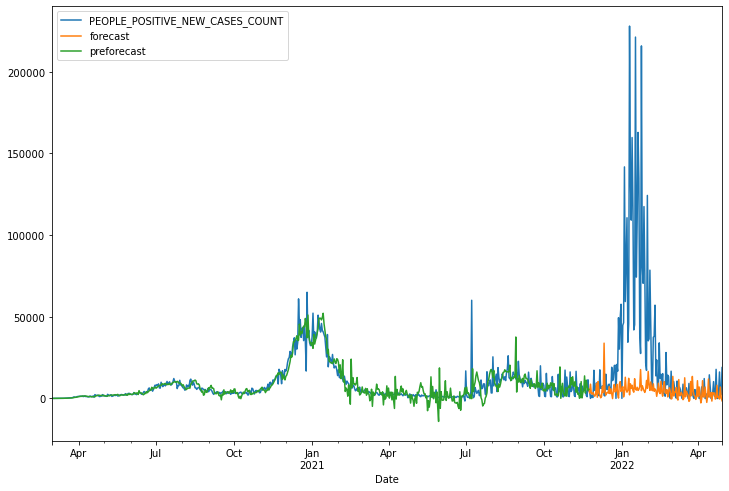

In [30]:
model=sm.tsa.statespace.SARIMAX(cali_train,order=(2, 1, 2),seasonal_order=(2,2,1,52)) # changed to 52
results=model.fit()
covid_df['forecast']=results.forecast(steps = len(cali_test))
covid_df['preforecast'] = results.predict(start = 0, end = 632)
covid_df[['PEOPLE_POSITIVE_NEW_CASES_COUNT','forecast', 'preforecast']].plot(figsize=(12,8))